In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='/Users/asadmolayari/Desktop/my_courses/pytorch/Data', train=True, \
                            download=True, transform=transform)

test_data = datasets.MNIST(root = '/Users/asadmolayari/Desktop/my_courses/pytorch/Data',\
                           train=False, download=True, transform=transform)


In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/asadmolayari/Desktop/my_courses/pytorch/Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /Users/asadmolayari/Desktop/my_courses/pytorch/Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
train_loader = DataLoader(train_data, batch_size=6, shuffle=True)
test_loader = DataLoader(test_data, batch_size=6, shuffle=False)

In [48]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)
        

In [49]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [54]:
import time
start_time = time.time()

epochs =3

train_losses =[]
test_losses = []
trn_correct =[]
tst_correct =[]

for i in range(epochs):
    trn_corr = 0
    tst_crr= 0
    
    for b, (X_train, y_train) in enumerate (train_loader):
        b+=1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted==y_train).sum()
        
        trn_corr+=batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600==0:
            print(f"Epoch {i} Batch {b} Loss: {loss.item()}")
            
    train_losses.append(loss)
    trn_correct.append(trn_corr)
    
    with torch.no_grad():
        
        for b, (X_test, y_test) in enumerate (test_loader):
            
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            
            tst_crr += (predicted==y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    tst_correct.append(tst_crr)
        

Epoch 0 Batch 600 Loss: 0.003898182651028037
Epoch 0 Batch 1200 Loss: 0.010948051698505878
Epoch 0 Batch 1800 Loss: 0.23084469139575958
Epoch 0 Batch 2400 Loss: 0.00012789636093657464
Epoch 0 Batch 3000 Loss: 0.0012569258688017726
Epoch 0 Batch 3600 Loss: 7.392215047730133e-05
Epoch 0 Batch 4200 Loss: 0.00021580560132861137
Epoch 0 Batch 4800 Loss: 0.0028372991364449263
Epoch 0 Batch 5400 Loss: 5.8124554925598204e-05
Epoch 0 Batch 6000 Loss: 0.03180611506104469
Epoch 0 Batch 6600 Loss: 8.742003387851582e-07
Epoch 0 Batch 7200 Loss: 0.013961280696094036
Epoch 0 Batch 7800 Loss: 0.002210821956396103
Epoch 0 Batch 8400 Loss: 0.0011053503258153796
Epoch 0 Batch 9000 Loss: 0.19203799962997437
Epoch 0 Batch 9600 Loss: 0.004445312544703484
Epoch 1 Batch 600 Loss: 3.7310215702746063e-05
Epoch 1 Batch 1200 Loss: 2.948258952528704e-05
Epoch 1 Batch 1800 Loss: 0.000187613011803478
Epoch 1 Batch 2400 Loss: 0.0002236874570371583
Epoch 1 Batch 3000 Loss: 0.002826773328706622
Epoch 1 Batch 3600 Loss:

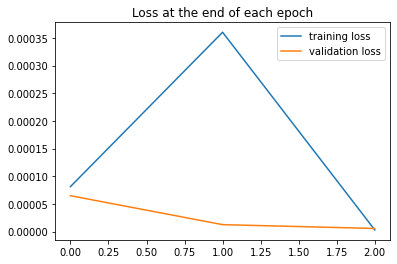

In [55]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

While there may be some overfitting of the training data, there is far less than we saw with the ANN model.

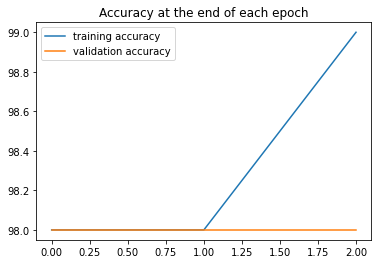

In [56]:
plt.plot([t/600 for t in trn_correct], label='training accuracy')
plt.plot([t/100 for t in tst_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [23]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [24]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9848/10000 =  98.480%
